In [42]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

#normalise the input data
input_data_raw = np.array([[0.1283970, 16.92780], 
                           [0.0571957, 1.84931], 
                           [0.1637660, 3.72207],
                           [0.1767490, 12.51520], 
                           [0.0794834, 9.15597], 
                           [0.0933685,	4.11090], 
                           [0.0120645,	8.79247], 
                           [0.0631101, 10.67490], 
                           [0.1548780,	2.79451],
                           [0.1024480,	0.15698], 
                           [0.0013705, 5.03365], 
                           [0.0302337, 11.55950],
                           [0.1971570,	7.37160],
                           #optimisation points - comment out to see original graphs
                           [0.1396969696969697, 15.959595959595958],
                           [0.161808081, 8.888888889],
                           [0.2, 20.0],
                           [0.1798989898989899, 17.97979797979798]
                           ])

normalizer = Normalizer()
scaler_input = MinMaxScaler()

input_data = scaler_input.fit_transform(input_data_raw)

#standardise the output data
output_value_raw = np.array([1.9075, 
                             2.0825, 
                             1.7975, 
                             1.7625, 
                             2.103, 
                             2.025, 
                             2.03, 
                             2.035, 
                             2.02, 
                             1.845,
                             2.13822, 
                             3.12001, 
                             3.120128,
                             #optimisation points - comment out to see original graphs
                             1.875,
                             1.81135,
                             1.65665,
                             1.7335
                             ])

output_value_raw = output_value_raw.reshape(-1, 1)
scaler_output = StandardScaler()
output_value = scaler_output.fit_transform(output_value_raw)

#normalise the whole range too
k_raw = np.linspace(0.001, 0.2, 100)
# Normalize the array
min_val = np.min(k_raw)
max_val = np.max(k_raw)
k = (k_raw - min_val) / (max_val - min_val)

inlet_speed_raw = np.linspace(0,20,100)
# Normalize the array
min_val1 = np.min(inlet_speed_raw)
max_val1 = np.max(inlet_speed_raw)
inlet_speed = (inlet_speed_raw - min_val1) / (max_val1 - min_val1)


#used to turn the two input variables into a single array
combinations = [(x, y) for x in k for y in inlet_speed]
all_points = np.array(combinations)


In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
import numpy as np

kernel = RBF()
# kernel = ConstantKernel(0.1, constant_value_bounds=(1e-5, 1e2)) * RBF(0.015, length_scale_bounds=(1e-5, 1e2))
gp_model = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=50)

#train gp model using initial training data
gp_model.fit(input_data, output_value)

# Generate predictions and expected improvement for all possible points using the Gaussian process model

def expected_improvement(x, gp_model, best_y, epsilon):
    y_pred, y_std = gp_model.predict(x, return_std=True)
    print('The standard deviation: ',y_std)
    z = (best_y - y_pred - epsilon)/y_std
    ei = ((best_y - y_pred - epsilon) * norm.cdf(z)) + y_std*norm.pdf(z)
    return ei, y_pred, y_std


best_idx = np.argmin(output_value)
best_y = output_value[best_idx]

print('The minimum value for the recirculation length is:',best_y)

#all_points is a 2d array of all combinations of wave height and boat speed that you want to look at
ei, y_pred, y_std = expected_improvement(all_points, gp_model, best_y, 0.01)

print(y_std.shape)

print(y_std)

print(ei.shape)
print('The best expected improvement is: ', ei[np.argmax(ei)], 'at co-ordinates', all_points[np.argmax(ei),0],',', all_points[np.argmax(ei),1])
print(np.min(y_pred))


The minimum value for the recirculation length is: [-0.99084047]
The standard deviation:  [6.79732956e-03 6.24731357e-03 5.72428280e-03 ... 4.74529282e-04
 2.47991530e-04 9.99998376e-06]
(10000,)
[6.79732956e-03 6.24731357e-03 5.72428280e-03 ... 4.74529282e-04
 2.47991530e-04 9.99998376e-06]
(10000,)
The best expected improvement is:  2.403578578777353 at co-ordinates 1.0 , 0.8787878787878787
-3.404419053345918


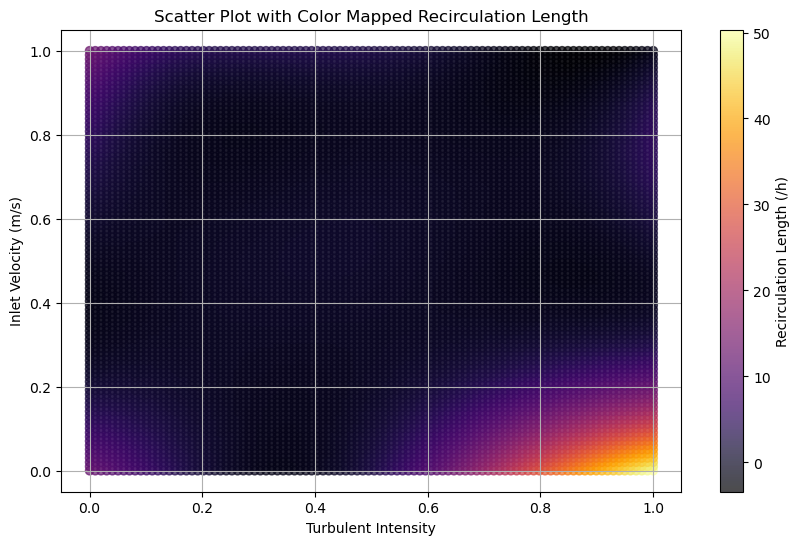

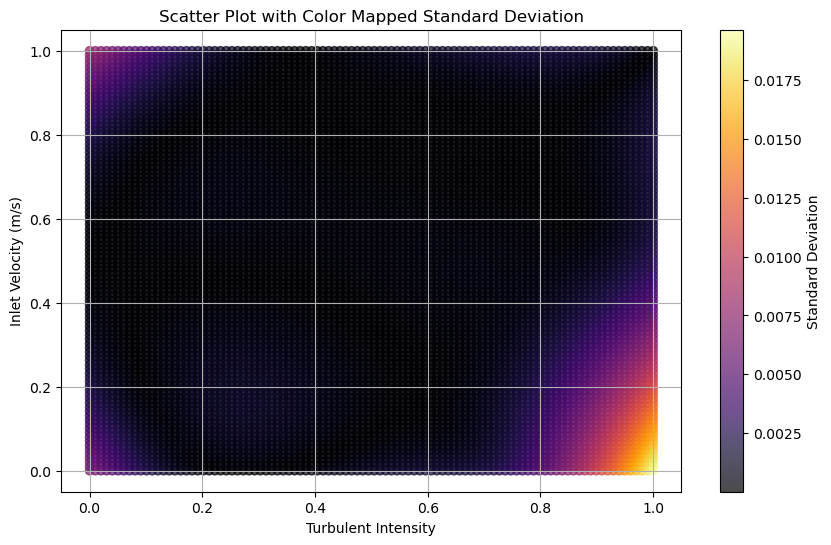

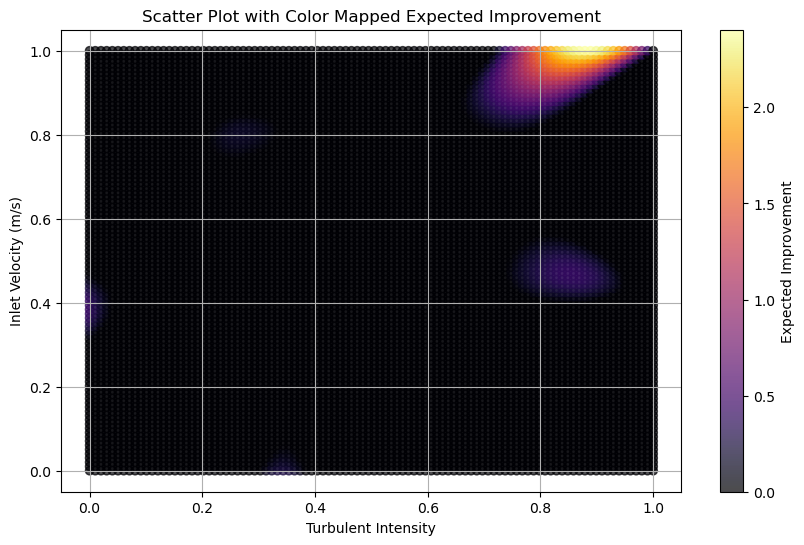

In [44]:
from matplotlib import pyplot as plt

#plot the prediction and standard deviation
X, Y = np.meshgrid(k, inlet_speed)

plt.figure(figsize=(10, 6))
#sc = plt.scatter(wave_height, boat_speed, c=y_pred, cmap='viridis', alpha=0.7)
sc = plt.scatter(X, Y, c=y_pred, cmap='inferno', alpha=0.7)
plt.colorbar(sc, label='Recirculation Length (/h)')
plt.xlabel('Turbulent Intensity')
plt.ylabel('Inlet Velocity (m/s)')
plt.title('Scatter Plot with Color Mapped Recirculation Length')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sc = plt.scatter(X, Y, c=y_std, cmap='inferno', alpha=0.7)
plt.colorbar(sc, label='Standard Deviation')
plt.xlabel('Turbulent Intensity')
plt.ylabel('Inlet Velocity (m/s)')
plt.title('Scatter Plot with Color Mapped Standard Deviation')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sc = plt.scatter(X, Y, c=ei, cmap='inferno', alpha=0.7)
plt.colorbar(sc, label='Expected Improvement')
plt.xlabel('Turbulent Intensity')
plt.ylabel('Inlet Velocity (m/s)')
plt.title('Scatter Plot with Color Mapped Expected Improvement')
plt.grid(True)
plt.show()

Lowest y pred [0.66799267]


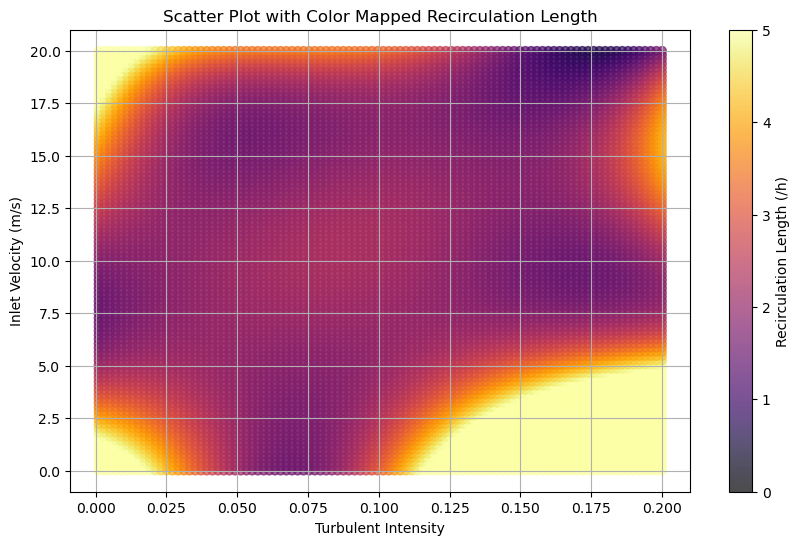

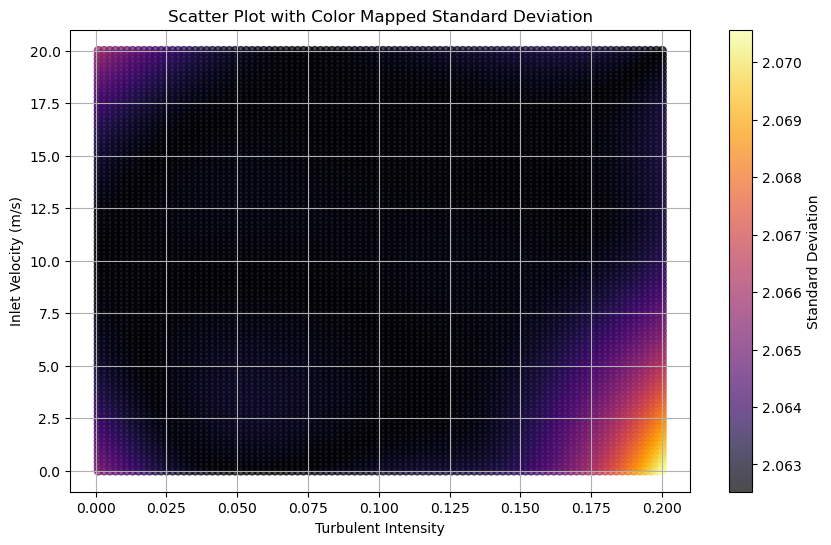

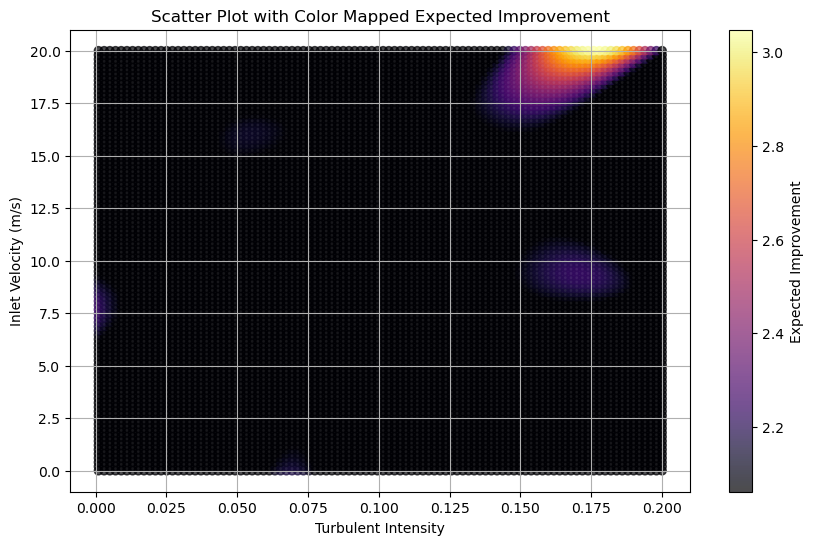

(10000, 1)
The best expected improvement is:  [3.04708215] at co-ordinates 0.2 , 17.575757575757574


In [53]:
#revert normalised and standardised data

#normalised data
#reverted_wave_height = scaler_input.inverse_transform(wave_height)
#reverted_boat_speed = scaler_input.inverse_transform(boat_speed)

combinations = [(x, y) for x in k_raw for y in inlet_speed_raw]
all_points_standard = np.array(combinations)

#standardised data
#reverted_y_pred = scaler_output.inverse_transform(y_pred)
#reverted_y_std = scaler_output.inverse_transform(y_std)
#reverted_ei = scaler_output.inverse_transform(ei)

# Reshape y_pred, y_std, and ei to have shape (n_samples, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)
y_std_reshaped = y_std.reshape(-1, 1)
ei_reshaped = ei.reshape(-1, 1)

# Revert the scaled output back to its original scale
reverted_y_pred = scaler_output.inverse_transform(y_pred_reshaped)
reverted_y_std = scaler_output.inverse_transform(y_std_reshaped)
reverted_ei = scaler_output.inverse_transform(ei_reshaped)

best_idx = np.argmin(reverted_y_pred)
best_y_pred = reverted_y_pred[best_idx]
print('Lowest y pred', best_y_pred)


#plot the prediction and standard deviation
rX, rY = np.meshgrid(k_raw, inlet_speed_raw)

plt.figure(figsize=(10, 6))
#sc = plt.scatter(wave_height, boat_speed, c=y_pred, cmap='viridis', alpha=0.7)
sc = plt.scatter(rX, rY, c=reverted_y_pred, cmap='inferno', alpha=0.7)
plt.colorbar(sc, label='Recirculation Length (/h)')
plt.clim(0, 5)
plt.xlabel('Turbulent Intensity')
plt.ylabel('Inlet Velocity (m/s)')
plt.title('Scatter Plot with Color Mapped Recirculation Length')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sc = plt.scatter(rX, rY, c=reverted_y_std, cmap='inferno', alpha=0.7)
plt.colorbar(sc, label='Standard Deviation')
plt.xlabel('Turbulent Intensity')
plt.ylabel('Inlet Velocity (m/s)')
plt.title('Scatter Plot with Color Mapped Standard Deviation')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sc = plt.scatter(rX, rY, c=reverted_ei, cmap='inferno', alpha=0.7)
plt.colorbar(sc, label='Expected Improvement')
plt.xlabel('Turbulent Intensity')
plt.ylabel('Inlet Velocity (m/s)')
plt.title('Scatter Plot with Color Mapped Expected Improvement')
plt.grid(True)
plt.show()

print(reverted_ei.shape)
print('The best expected improvement is: ', reverted_ei[np.argmax(reverted_ei)], 'at co-ordinates', all_points_standard[np.argmax(reverted_ei),0],',', all_points_standard[np.argmax(reverted_ei),1])